In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import sys
import pandas as pd
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel, RationalQuadratic
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(1, "C:\\Users\\12105\\GitHub")
from hypercube import LHSTuner, OFAT, Surf

In [2]:
x, y = make_classification(n_samples=500, n_features=10, 
                           class_sep=0.4, random_state=5)
params = {
    "C": [(0.01, 100), "log10"],
    "gamma": [(0.0005, 0.5), "log10"]
}
clf = SVC(random_state=1, kernel='rbf')

In [22]:
surf = Surf(clf, params, "recall", cv=4, random_state=1, step_size=[0.05, 0.05])
surf.fit(x, y)
surf_all = list(surf.best_param.values())

In [32]:
lhs = LHSTuner(clf, params, "recall", cv=4, random_state=1, n_samples=20)
ker = RBF() + Matern()
cube_all = []
# x1_all, x2_all = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
# result_matrix = np.column_stack((np.repeat(x1_all, len(x2_all)), np.tile(x2_all, len(x1_all))))
# pred_all = []
for i in range(5):
    lhs.fit(x, y, method='gp_fit', kernel=ker)
    cube_all.append(list(lhs.best_param.values()))
#     pred_all.append(lhs.m1.predict(result_matrix))
# cube_all = np.array(cube_all)
# agg_pred = np.array(pred_all).mean(axis=0)

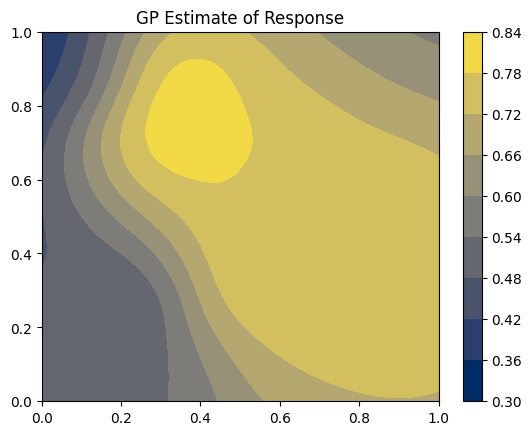

In [35]:
# xg1, xg2 = np.meshgrid(x1_all, x2_all)
# plt.figure()
# cp = plt.contourf(xg1, xg2, agg_pred.reshape(-100, 100).T, 
#                   cmap='cividis')
# plt.colorbar(cp)
# plt.title("GP Estimate of Response")
# plt.show()

In [14]:
from sklearn.metrics import recall_score
from copy import deepcopy
from sklearn.model_selection import KFold

def run_cv(x: np.ndarray, y: np.ndarray, estimator: object, 
           cv: int, random_state: int):
    
    score, copy_estimator = [], deepcopy(estimator)
    for train_idx, val_idx in KFold(n_splits=cv, shuffle=True,
                                      random_state=random_state).split(x, y):
        train_x, train_y = x[train_idx], y[train_idx]
        val_x, val_y = x[val_idx], y[val_idx]
        copy_estimator.fit(train_x, train_y)
        pred_y = copy_estimator.predict(val_x)
        score.append(recall_score(val_y, pred_y))

    return np.mean(score)

In [15]:
from hyperopt import fmin, tpe, hp

def objective(params):
    # Convert 'C' and 'gamma' to log scale
    params['C'] = np.exp(params['C'])
    params['gamma'] = np.exp(params['gamma'])
    model = SVC(**params, kernel='rbf')
    score = run_cv(x, y, model, cv=4, random_state=1)
    return -score

# Define the search space
space = {
    'C': hp.uniform('C', -2, 2), 
    'gamma': hp.uniform('gamma', -3.30103, -0.30103)  
}
hp_all = []
for i in range(5):
    hp_param = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)
    hp_all.append([np.exp(hp_param['C']), np.exp(hp_param['gamma'])])
hp_all = np.array(hp_all)

100%|██████████| 20/20 [00:01<00:00, 14.82trial/s, best loss: -0.8139226886097373]


### Optuna

In [16]:
import optuna

def objective(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)  
    gamma = trial.suggest_float('gamma', 0.0005, 0.5, log=True)  
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    score = run_cv(x, y, model, cv=4, random_state=1)
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
opn_all = []
for i in range(5):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    opn_all.append(list(study.best_params.values()))
opn_all = np.array(opn_all)

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint, loguniform

r_param = dict(C=loguniform(0.01, 100),
               gamma=loguniform(0.0005, 0.5))
r_all = []
for i in range(5):
    r = RandomizedSearchCV(clf, r_param, cv=4, n_iter=20, 
                           scoring="recall")
    r.fit(x, y)
    r_all.append(list(r.best_params_.values()))
r_all = np.array(r_all)

In [18]:
c = list(np.logspace(np.log10(0.001), np.log10(100), 80))
gamma = list(np.logspace(np.log10(0.0005), np.log10(0.5), 80))
g_param = {"C": c, "gamma": gamma}
ofat = OFAT(clf, g_param, metric="recall", cv=4, random_state=1)
ofat.fit(x, y, "anova")

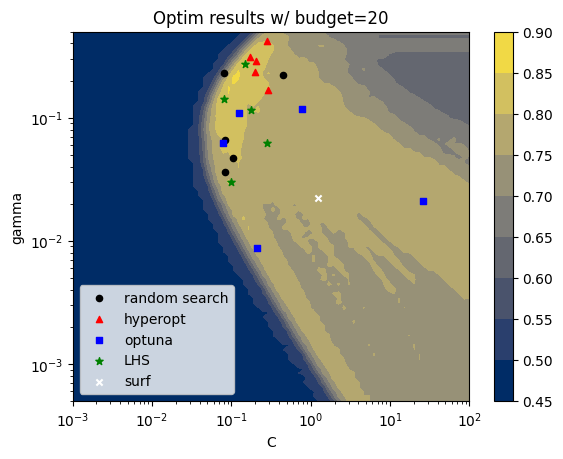

In [34]:
C1, G1 = np.meshgrid(c, gamma)
plt.figure()
cp = plt.contourf(C1, G1, ofat.exp_result.mean(axis=1).reshape(-80, 80).T, 
                  cmap='cividis')
plt.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.scatter(r_all[:, 0], r_all[:, 1], color="black", 
            label="random search", s=20, marker="o")
plt.scatter(hp_all[:, 0], hp_all[:, 1], color='red', 
            label='hyperopt', s=20, marker="^")
plt.scatter(opn_all[:, 0], opn_all[:, 1], color='blue',
            label='optuna', s=15, marker="s")
plt.scatter(cube_all[:, 0], cube_all[:, 1], color='green',
            label='LHS', s=30, marker="*")
plt.scatter(surf_all[0], surf_all[1], color='white',
            label='surf', s=20, marker='x')
plt.xlabel("C")
plt.ylabel("gamma")
plt.title("Optim results w/ budget=20")
plt.legend(loc="lower left")
plt.show()

In [41]:
lhs = LHSTuner(clf, params, "recall", cv=4, random_state=1, n_samples=9)
ker = RBF() + Matern()
cube_all = []
for i in range(5):
    lhs.fit(x, y, method='gp_fit', kernel=ker)
    cube_all.append(list(lhs.best_param.values()))
cube_all = np.array(cube_all)

In [42]:
def objective(params):
    # Convert 'C' and 'gamma' to log scale
    params['C'] = np.exp(params['C'])
    params['gamma'] = np.exp(params['gamma'])
    model = SVC(**params, kernel='rbf')
    score = run_cv(x, y, model, cv=4, random_state=1)
    return -score

# Define the search space
space = {
    'C': hp.uniform('C', -2, 2), 
    'gamma': hp.uniform('gamma', -3.30103, -0.30103)  
}
hp_all = []
for i in range(5):
    hp_param = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)
    hp_all.append([np.exp(hp_param['C']), np.exp(hp_param['gamma'])])
hp_all = np.array(hp_all)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:00<00:00, 14.66trial/s, best loss: -0.8116638216541924]


In [43]:
def objective(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)  
    gamma = trial.suggest_float('gamma', 0.0005, 0.5, log=True)  
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    score = run_cv(x, y, model, cv=4, random_state=1)
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
opn_all = []
for i in range(5):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    opn_all.append(list(study.best_params.values()))
opn_all = np.array(opn_all)

In [44]:
r_param = dict(C=loguniform(0.01, 100),
               gamma=loguniform(0.0005, 0.5))
r_all = []
for i in range(5):
    r = RandomizedSearchCV(clf, r_param, cv=4, n_iter=10, 
                           scoring="recall")
    r.fit(x, y)
    r_all.append(list(r.best_params_.values()))
r_all = np.array(r_all)

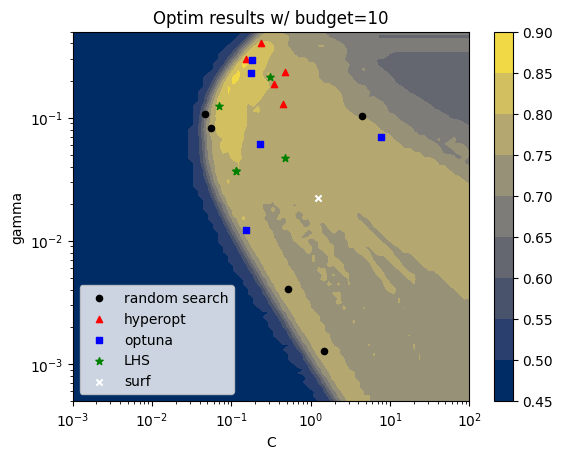

In [46]:
C1, G1 = np.meshgrid(c, gamma)
plt.figure()
cp = plt.contourf(C1, G1, ofat.exp_result.mean(axis=1).reshape(-80, 80).T, 
                  cmap='cividis')
plt.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.scatter(r_all[:, 0], r_all[:, 1], color="black", 
            label="random search", s=20, marker="o")
plt.scatter(hp_all[:, 0], hp_all[:, 1], color='red', 
            label='hyperopt', s=20, marker="^")
plt.scatter(opn_all[:, 0], opn_all[:, 1], color='blue',
            label='optuna', s=15, marker="s")
plt.scatter(cube_all[:, 0], cube_all[:, 1], color='green',
            label='LHS', s=30, marker="*")
plt.scatter(surf_all[0], surf_all[1], color='white',
            label='surf', s=20, marker='x')
plt.xlabel("C")
plt.ylabel("gamma")
plt.title("Optim results w/ budget=10")
plt.legend()
plt.show()

In [2]:
from sklearn.ensemble import RandomForestClassifier

x, y = make_classification(n_samples=300, n_features=10, 
                           class_sep=0.5, random_state=42)
rf_param = {
    "n_estimators": [(30, 100), "unif"],
    "min_samples_leaf": [(2, 10), "unif"]
}
rf = RandomForestClassifier(random_state=1)
surf = Surf(rf, rf_param, "recall", cv=5, random_state=1, step_size=[0.05, 0.05])
surf.fit(x, y)

In [3]:
surf.best_param

{'n_estimators': 80, 'min_samples_leaf': 6}

In [4]:
surf.best_score

0.8317399999999999